# Lecture 04 - Categories & Curves

In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))  # make src importable

# Project modules
import init_notebook
import utils

# Third-party libs – explicit per notebook
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr

# Run the setup
init_notebook.setup()

Using style file: /Users/gharda/Documents/Code/statistical-rethinking-pymc/statistical-rethinking-pymc.mplstyle
Module aliases imported by init_notebook.py:
--------------------------------------------
import np
import pd
import smf
import pm
import xr
import az
import stats
import plt
import utils
Watermark:
----------
Last updated: 2025-12-06T11:32:15.576186+07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.7.0

Compiler    : Clang 17.0.0 (clang-1700.3.19.1)
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.10.7
arviz      : 0.22.0
statsmodels: 0.14.5
xarray     : 2025.11.0
pytensor   : 2.35.1
pathlib    : 1.0.1
scipy      : 1.16.3
pymc       : 5.26.1
numpy      : 2.3.5
pandas     : 2.3.3
watermark  : 2.5.0



## Linear Regression & Drawing Inferences
- Can be used to approximate most anything, even nonlinear phenomena (e.g. GLMs)
- We need to incorporate causal thinking into...
    - ...how we compose statistical models
    - ...how we process and interpret results

## Categories
- non-continuous causes
- discrete, unordered types
- stratifying by category: fit a separate regression (e.g. line) to each

### Revisiting the Howell dataset

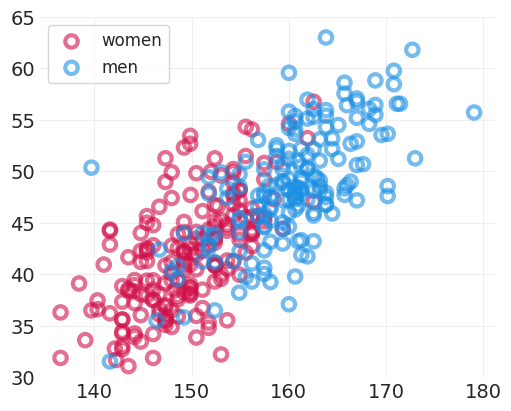

In [5]:
HOWELL = utils.load_data("Howell1")

# Adult data
ADULT_HOWELL = HOWELL[HOWELL.age >= 18]

# Split by the Sex Category
SEX = ['women', 'men']

plt.subplots(figsize=(5, 4))
for ii, label in enumerate(SEX):
    utils.plot_scatter(
        ADULT_HOWELL[ADULT_HOWELL.male == ii].height,
        ADULT_HOWELL[ADULT_HOWELL.male == ii].weight,
        color = f"C{ii}",
        label = label
    )
plt.ylim([30, 65])
plt.legend()

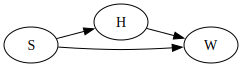

In [6]:
# Draw the mediation graph
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
    ],
    graph_direction = "LR"
)

### Think scientifically first
- How are height, weight, and sec **causally** related?
- How are height, weight, and sex **statistically** related?

#### The causes aren't in the data
Height should affect weight, not vice versa
- ✅ $H \rightarrow W$
- ❌ $H \leftarrow W$

Sex should affect height, not vice versa
- ❌ $H \rightarrow S$
- ✅ $H \leftarrow S$

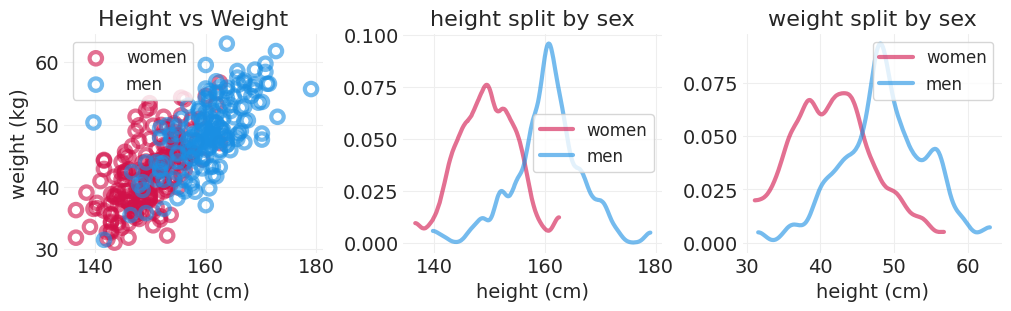

In [7]:
# Split height by the Sex Category
def plot_height_weight_distribution(data):
    fig, axs = plt.subplots(1, 3, figsize = (10, 3))
    plt.sca(axs[0])
    
    for ii, label in enumerate(SEX):
        utils.plot_scatter(
            data[data.male == ii].height,
            data[data.male == ii].weight,
            color = f"C{ii}",
            label = label
        )
    plt.xlabel("height (cm)")
    plt.ylabel("weight (kg)")
    plt.legend()
    plt.title("Height vs Weight")
    
    for vv, var in enumerate(['height', 'weight']):
        plt.sca(axs[vv + 1])
        for ii in range(2):
            az.plot_dist(
                data.loc[data.male == ii, var].values,
                color = f"C{ii}",
                label = SEX[ii],
                bw = 1,
                plot_kwargs = dict(linewidth = 3, alpha = .6),
            )
        plt.title(f"{var} split by sex")
        plt.xlabel("height (cm)")
        plt.legend();
        
plot_height_weight_distribution(ADULT_HOWELL)

Causal graph defines a set of functional relationships
$$
\begin{align}
H & = f_H(S) \\
W & = f_W(H,S)
\end{align}
$$

Could also include unobservable causal influence $T$ on $S$ (see below graph):
$$
\begin{align}
H & = f_H(S, U) \\
W & = f_W(H,S, V) \\
S & = f_S(T)
\end{align}
$$

> Note: we use $T$ as an unobserved variable, rather than $W$ to avoid replication in the lecture.

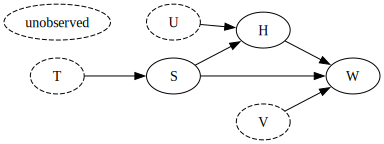

In [8]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
        ("V", "W"),
        ("U", "H"),
        ("T", "S")
    ],
    node_props={
        "T": {"style": "dashed"},
        "U": {"style": "dashed"},
        "V": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

#### Synthetic People

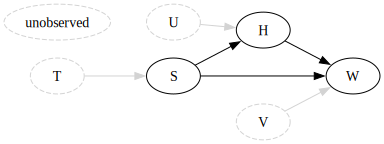

In [9]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
        ("V", "W"),
        ("U", "H"),
        ("T", "S")
    ],
    node_props={
        "T": {"style": "dashed", "color": "lightgray"},
        "U": {"style": "dashed", "color": "lightgray"},
        "V": {"style": "dashed", "color": "lightgray"},
        "unobserved": {"style": "dashed", "color": "lightgray"}
    },
    edge_props={
        ("T", "S"): {"color": "lightgray"},
        ("U", "H"): {"color": "lightgray"},
        ("V", "W"): {"color": "lightgray"}
    },
    graph_direction="LR"
)

,height,weight,male
0,166.107023,171.404377,1
1,157.695548,156.455119,0
2,163.781893,166.020360,1
3,165.141813,164.737152,1
4,161.185590,155.953917,1


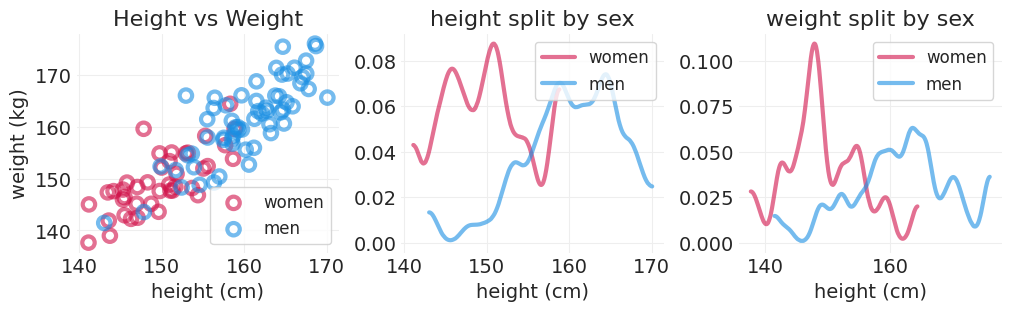

In [10]:
def simulate_sex_height_weight(
    S: np.ndarray,
    beta: np.ndarray = np.array([1, 1]),
    alpha: np.ndarray = np.array([0, 0]),
    female_mean_height: float = 150,
    male_mean_height: float = 160
) -> np.ndarray:
    """
    Generative model for the effect of Sex on height & weight
    
    S: np.array[int]
        The 0/1 indicator variable sex. 1 means 'male'
    beta: np.array[float]
        Lenght 2 slope coefficient for each sex
    alpha: np.array[float]
        Length 2 intercept for each sex
    """
    N = len(S)
    H = np.where(S, male_mean_height, female_mean_height) + stats.norm(0, 5).rvs(size = N)
    W = alpha[S] + beta[S] * H + stats.norm(0, 5).rvs(size = N)
    
    return pd.DataFrame({"height": H, "weight": W, "male": S})

synthetic_sex = stats.bernoulli(p = .5).rvs(size = 100).astype(int)
synthetic_people = simulate_sex_height_weight(S = synthetic_sex)
plot_height_weight_distribution(synthetic_people)
synthetic_people.head()

#### Think scientifically first
Different causal questions require different statistical models:
- Question 1: What's the causal effect of $H$ on $W$?
- Question 2: What's the **Total** Causal effect of $S$ on $W$?
- Question 3: What's the **Direct** Causal effect of $S$ on $W$?

Answering the last two questions requires different statistical models, but both will need stratification by $S$

#### From estimand to estimate
##### Causal effect of $H$ on $W$ (Q1)

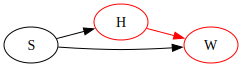

In [15]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "H": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("H", "W"): {"color": "red"},
    },
    graph_direction="LR"
)

In [16]:
##### **Total** Causal effect of $S$ on $W$ (Q2)

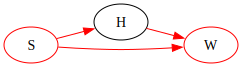

In [17]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "W"): {"color": "red"},
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

##### **Direct** Causal effect of $S$ on $W$ (Q3)

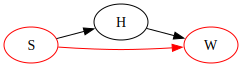

In [18]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

**Stratify by S**: recover a different estimate for each value that $S$ can take

#### Drawing the Causal Owl
Implement Categories via **Indicator Variables**
- generalizes code: can extend to any number of categories
- better for prior-specification
- facilitates multi-level model specification

For categories $C = [C_1, C_2, ..., C_D]$

$$
\begin{align}
\alpha & = [\alpha_1, \alpha_2, ..., \alpha_D] \\
y_i & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha_{c[i]}
\end{align}
$$

For sex $S \in \{M, F\}$, we can model sex-specific weight $W$ as

$$
\begin{align}
W_i & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha_{s[i]} \\
\alpha & = [\alpha_{F}, \alpha_{M}] \\
\alpha_j & \sim \text{Normal}(60, 10)\\
\sigma & \sim \text{Uniform}(0,10)
\end{align}
$$

#### Testing
##### Total Causal Effect of Sex on Weight

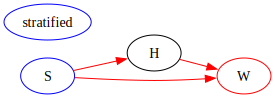

In [19]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "blue"},
        "W": {"color": "red"},
        "stratified": {"color": "blue"}
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "W"): {"color": "red"},
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

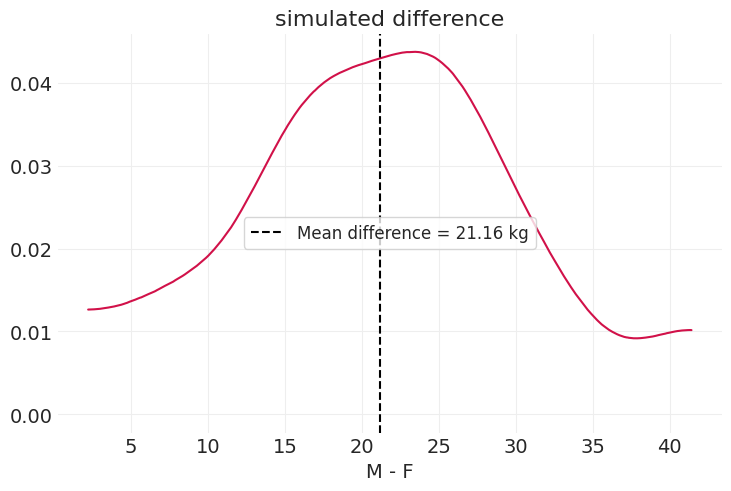

In [23]:
np.random.seed(12345)
n_simulations = 100
simulated_females = simulate_sex_height_weight(
    S = np.zeros(n_simulations).astype(int),
    beta = np.array((0.5, 0.6))
)

simulated_males = simulate_sex_height_weight(
    S = np.ones(n_simulations).astype(int),
    beta = np.array((0.5, 0.6))
)
    
simulated_delta = simulated_males - simulated_females
mean_simulated_delta = simulated_delta.mean()
az.plot_dist(simulated_delta['weight'].values)
plt.axvline(
    mean_simulated_delta['weight'],
    color = 'k',
    linestyle = '--',
    label = f"Mean difference = {mean_simulated_delta['weight']:.2f} kg"
)
plt.xlabel("M - F")
plt.legend()
plt.title("simulated difference");